In [149]:
import sys

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

import librosa
import librosa.display
import IPython.display as display

sys.path.append('../src')
import const
from metrics import row_wise_micro_averaged_f1_score

In [150]:
train_df = pd.read_csv('../data/input/train_soundscape_labels.csv')

oof4 = np.load("../logs/exp_004_20210409202215_0.701/oof.npy")
oof10 = np.load("../logs/exp_010_20210412203406_0.684/oof.npy")
oof11 = np.load("../logs/exp_011_20210413092718_0.710/oof.npy")
oof12 = np.load("../logs/exp_012_20210413202510_0.700/oof.npy")
oof20 = np.load("../logs/exp_020_20210420203023_0.698/oof.npy")

concat_oof = np.concatenate([
    oof4[np.newaxis, :, :],
    oof10[np.newaxis, :, :],
    oof11[np.newaxis, :, :],
    oof12[np.newaxis, :, :],
    oof20[np.newaxis, :, :],
], axis=0)

oof = np.mean(concat_oof, axis=0)

In [151]:
events = oof >= 0.7
nocall_col = np.zeros((len(oof), 1)).astype(bool)
nocall_col[events.sum(1) == 0] = True
events = np.concatenate([events, nocall_col], axis=1)
oof_labels = list(
    map(
        lambda x: const.INV_BIRD_CODE[x],
        np.argwhere(events)[:, 1].reshape(-1).tolist(),
    )
)

row_wise_micro_averaged_f1_score(oof_labels1, train_df["birds"].values)

0.7004166666666536

In [152]:
train_df["oof_birds"] = oof_labels

In [153]:
train_df["nocall_birds"] = 0
train_df.loc[train_df[train_df["birds"] == "nocall"].index, "nocall_birds"] = 1

train_df["nocall_oof_birds"] = 0
train_df.loc[train_df[train_df["oof_birds"] == "nocall"].index, "nocall_oof_birds"] = 1

In [154]:
train_df["acc"] = train_df["birds"] == train_df["oof_birds"]
train_df.head()

,row_id,site,audio_id,seconds,birds,oof_birds,nocall_birds,nocall_oof_birds,acc
0,7019_COR_5,COR,7019,5,nocall,nocall,1,1,True
1,7019_COR_10,COR,7019,10,nocall,nocall,1,1,True
2,7019_COR_15,COR,7019,15,nocall,nocall,1,1,True
3,7019_COR_20,COR,7019,20,nocall,nocall,1,1,True
4,7019_COR_25,COR,7019,25,nocall,nocall,1,1,True


In [155]:
train_df["diff"] = (train_df["birds"].apply(lambda x: 1 if x == "nocall" else 0) - 
                                 train_df["oof_birds"].apply(lambda x: 1 if x == "nocall" else 0))

In [156]:
train_df["diff"].value_counts()

 0    1659
-1     740
 1       1
Name: diff, dtype: int64

つまり、何かしらの鳥の鳴き声が聞こえているのに `nocall`と予測しているパターンが多いのか

In [157]:
train_df[~train_df["acc"]]

,row_id,site,audio_id,seconds,birds,oof_birds,nocall_birds,nocall_oof_birds,acc,diff
240,11254_COR_5,COR,11254,5,rubwre1,nocall,0,1,False,-1
242,11254_COR_15,COR,11254,15,rubwre1,nocall,0,1,False,-1
267,11254_COR_140,COR,11254,140,obnthr1,nocall,0,1,False,-1
268,11254_COR_145,COR,11254,145,obnthr1,nocall,0,1,False,-1
269,11254_COR_150,COR,11254,150,obnthr1,nocall,0,1,False,-1
...,...,...,...,...,...,...,...,...,...,...
2388,54955_SSW_545,SSW,54955,545,chswar,nocall,0,1,False,-1
2390,54955_SSW_555,SSW,54955,555,chswar,nocall,0,1,False,-1
2391,54955_SSW_560,SSW,54955,560,grycat,nocall,0,1,False,-1
2396,54955_SSW_585,SSW,54955,585,grycat,nocall,0,1,False,-1


In [158]:
for audio_id in train_df["audio_id"].unique():
    print(f"audio_id: {audio_id}")
    print("-" * 50)
    print(train_df[train_df["audio_id"] == audio_id]['birds'].value_counts())
    print("\n")
    print(train_df[(~train_df["acc"]) & (train_df["audio_id"] == audio_id)]["diff"].value_counts())
    print("\n" * 2)

audio_id: 7019
--------------------------------------------------
nocall    120
Name: birds, dtype: int64


Series([], Name: diff, dtype: int64)



audio_id: 7954
--------------------------------------------------
nocall    120
Name: birds, dtype: int64


Series([], Name: diff, dtype: int64)



audio_id: 11254
--------------------------------------------------
nocall            105
obnthr1             6
rubwre1             5
brnjay              3
brnjay sthwoo1      1
Name: birds, dtype: int64


-1    11
Name: diff, dtype: int64



audio_id: 18003
--------------------------------------------------
rucwar                    84
nocall                    24
hofwoo1                    3
rucwar runwre1             3
hofwoo1 rucwar             2
rtlhum rucwar              1
grekis rucwar              1
hofwoo1 rucwar runwre1     1
runwre1                    1
Name: birds, dtype: int64


-1    81
 0     2
Name: diff, dtype: int64



audio_id: 21767
--------------------------------------------

In [176]:
def show_top_birds(preds_array, top_n=5):
    top_preds = np.sort(preds_array)[:-(top_n + 1):-1]
    top_bird_codes = np.argsort(preds_array)[:-(top_n + 1):-1]

    top_birds = [const.INV_BIRD_CODE[c] for c in top_bird_codes]
    
    plt.figure(figsize=(16, 5))
    plt.bar(top_birds, top_preds)
    plt.ylim([0, 0.5])

In [177]:
train_df[(train_df["acc"]) & (train_df["birds"] != "nocall")].head(50)

,row_id,site,audio_id,seconds,birds,oof_birds,nocall_birds,nocall_oof_birds,acc,diff
244,11254_COR_25,COR,11254,25,rubwre1,rubwre1,0,0,True,0
272,11254_COR_165,COR,11254,165,obnthr1,obnthr1,0,0,True,0
342,11254_COR_515,COR,11254,515,rubwre1,rubwre1,0,0,True,0
343,11254_COR_520,COR,11254,520,rubwre1,rubwre1,0,0,True,0
387,18003_COR_140,COR,18003,140,rucwar,rucwar,0,0,True,0
388,18003_COR_145,COR,18003,145,rucwar,rucwar,0,0,True,0
389,18003_COR_150,COR,18003,150,rucwar,rucwar,0,0,True,0
391,18003_COR_160,COR,18003,160,rucwar,rucwar,0,0,True,0
403,18003_COR_220,COR,18003,220,rucwar,rucwar,0,0,True,0
404,18003_COR_225,COR,18003,225,rucwar,rucwar,0,0,True,0


In [179]:
data, sr = librosa.load("../data/input/train_soundscapes/11254_COR_20190904.ogg")

In [184]:
idx = 272

t = train_df.loc[idx, "seconds"]
display.Audio(data[sr * (t - 5): sr * t], rate=sr)

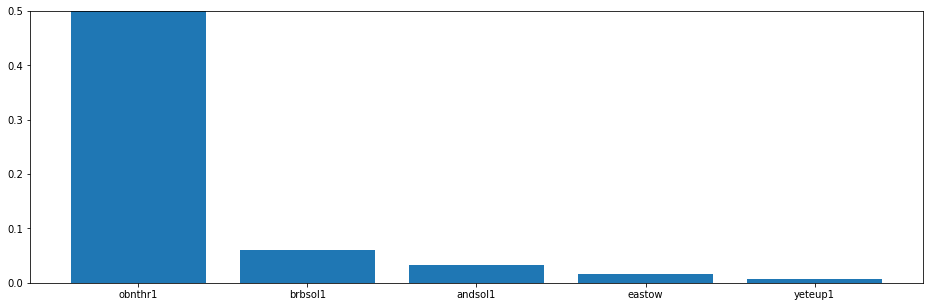

In [185]:
show_top_birds(oof[idx, :])